In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
#@title Setup Environment
# Install the latest Tensorflow version.
!pip3 install tensorflow_text

In [ ]:
!pip install pytorch-pretrained-bert pytorch-nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 KB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 92.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 23.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Introduction


In this analysis, we will discuss how you can use NLP to determine whether the news is real or fake. Nowadays, fake news has become a common problem. Even respected media organizations are known to propagate fake news and are losing credibility. It can be difficult to trust news, because it can be difficult to know whether a news story is real or fake.

# Dataset
1.train.csv: A full training dataset with the following attributes
2.id: unique id for a news article
3.title: the title of a news article
4.author: author of the news article
5.text: the text of the article; could be incomplete
6.label: a label that marks the article as potentially unreliable. Where 0: reliable and 1: unreliable.

# Importing important libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [ ]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
#from pytorch_pretrained_bert import BertTokenizer, BertConfig
#from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

# Reading dataset

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/research/aireserchnlp/fakenews/try2/fakdata/train.csv')



In [ ]:
# here we are printing first five lines of our train dataset
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Data Pre-Processing

In [ ]:
#filling nan values with space(' ')
train_df.fillna(' ',inplace=True)

In [ ]:
#combining title and author,title and summary is formed
train_df['summary']=train_df['title']+' '+train_df['author']+' '+train_df['text']
train_df.head()

,id,title,author,text,label,summary
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...


In [ ]:
train_df['summary'][1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates

In [ ]:
train_df.isnull().sum()

id         0
title      0
author     0
text       0
label      0
summary    0
dtype: int64

In [ ]:
train_df['summary']==' '

0        False
1        False
2        False
3        False
4        False
         ...  
20795    False
20796    False
20797    False
20798    False
20799    False
Name: summary, Length: 20800, dtype: bool

In [ ]:
# here we are importing nltk,stopwords and porterstemmer we are using stemming on the text
# we have and stopwords will help in removing the stopwords in the text

#re is regular expressions used for identifying only words in the text and ignoring anything else
import nltk
import re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
ps=PorterStemmer()

In [ ]:
x=train_df['summary']
y=train_df['label']

In [ ]:
x.head()

0    House Dem Aide: We Didn’t Even See Comey’s Let...
1    FLYNN: Hillary Clinton, Big Woman on Campus - ...
2    Why the Truth Might Get You Fired Consortiumne...
3    15 Civilians Killed In Single US Airstrike Hav...
4    Iranian woman jailed for fictional unpublished...
Name: summary, dtype: object

In [ ]:
x[1]

'FLYNN: Hillary Clinton, Big Woman on Campus - Breitbart Daniel J. Flynn Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
#X_train, X_test, y_train, y_test = train_test_split(np.array(corpus),np.array(y), stratify=y)
X_train, X_test, y_train, y_test = train_test_split(x,y, stratify=y)

#Now lets import BERT model and get embeding vectors for few sample statements

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']



see it on some sentence

In [ ]:
get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.51327276, -0.88845724, ..., -0.74748844,
        -0.7531474 ,  0.91964495],
       [-0.87208337, -0.5054394 , -0.94446665, ..., -0.85847497,
        -0.71745324,  0.8808295 ]], dtype=float32)>

#Build Model

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
len(X_train)

15600

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
488/488 [==============================] - 188s 368ms/step - loss: 0.5938 - accuracy: 0.6804 - precision: 0.6871 - recall: 0.6643
Epoch 2/10
488/488 [==============================] - 182s 374ms/step - loss: 0.4978 - accuracy: 0.7669 - precision: 0.7795 - recall: 0.7452
Epoch 3/10
488/488 [==============================] - 184s 376ms/step - loss: 0.4569 - accuracy: 0.7949 - precision: 0.8079 - recall: 0.7745
Epoch 4/10
488/488 [==============================] - 183s 375ms/step - loss: 0.4313 - accuracy: 0.8090 - precision: 0.8204 - recall: 0.7918
Epoch 5/10
488/488 [==============================] - 183s 376ms/step - loss: 0.4173 - accuracy: 0.8179 - precision: 0.8283 - recall: 0.8028
Epoch 6/10
488/488 [==============================] - 184s 378ms/step - loss: 0.4052 - accuracy: 0.8235 - precision: 0.8318 - recall: 0.8114
Epoch 7/10
488/488 [==============================] - 182s 373ms/step - loss: 0.3970 - accuracy: 0.8254 - precision: 0.8360 - recall: 0.8102
Epoch 8/10
48

In [ ]:
model.evaluate(X_test, y_test)

163/163 [==============================] - 62s 374ms/step - loss: 0.3419 - accuracy: 0.8638 - precision: 0.8888 - recall: 0.8321


[0.34192731976509094,
 0.8638461828231812,
 0.8887977004051208,
 0.8321167826652527]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

163/163 [==============================] - 61s 370ms/step


In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[2326,  271],
       [ 437, 2166]])

Text(33.0, 0.5, 'Truth')

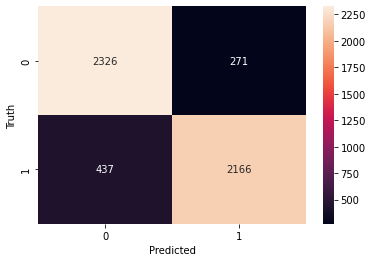

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2597
           1       0.89      0.83      0.86      2603

    accuracy                           0.86      5200
   macro avg       0.87      0.86      0.86      5200
weighted avg       0.87      0.86      0.86      5200

